In [2]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

import sys
sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import tiff_file
import ddm_clean 

import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

nd2reader module not found. Reading of .nd2 files disabled.


C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


## Image autocorrelation function defined below

In [3]:
def im_corr(im, filter=False, filtersize=80, bin=True, binsize=2):
    '''
    Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
        
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation
    '''
    # Crop image
    image = im[:1400, :1400]
        
    if bin:
        from skimage.transform import downscale_local_mean #For binning
        image = downscale_local_mean(image, (binsize,binsize), cval=1)
        
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #radial average taken
    rav_corr = ddm_clean.newRadav(corr_im)
    
    
    return corr_im, rav_corr

def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

def last_3chars(x):
    return((x.split('\\')[-1])[-7:-4])
#last_3chars(files[0])

###define function to find characteristic correlation lengths of SIA curves 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

one_over_e = 1.0/np.exp(1) #characteristic decay length 1/e = 0.36787944117144233... 
#print(one_over_e)

In [4]:
###################################################################################
# Specify where the data is and file name for image (or image sequence)           #
###################################################################################

directory = "Z"
exp = "8-15-22_s2_EA,WT,1-3WT"
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\reordered tiffs\\" #bottom_row_t01\\
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*.tif")
#files = sorted(files, key = last_3chars)
print("found %i files" % len(files))
print(int((len(files))/3))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 27 files
9
 0 	 bottom_row_t1.tif
 1 	 bottom_row_t2.tif
 2 	 bottom_row_t3.tif
 3 	 bottom_row_t4.tif
 4 	 bottom_row_t5.tif
 5 	 bottom_row_t6.tif
 6 	 bottom_row_t7.tif
 7 	 bottom_row_t8.tif
 8 	 bottom_row_t9.tif
 9 	 middle_row_t1.tif
 10 	 middle_row_t2.tif
 11 	 middle_row_t3.tif
 12 	 middle_row_t4.tif
 13 	 middle_row_t5.tif
 14 	 middle_row_t6.tif
 15 	 middle_row_t7.tif
 16 	 middle_row_t8.tif
 17 	 middle_row_t9.tif
 18 	 top_row_t1.tif
 19 	 top_row_t2.tif
 20 	 top_row_t3.tif
 21 	 top_row_t4.tif
 22 	 top_row_t5.tif
 23 	 top_row_t6.tif
 24 	 top_row_t7.tif
 25 	 top_row_t8.tif
 26 	 top_row_t9.tif


In [5]:
############################################################################################
# specify each condition (frame_names) and the time points of data collection (time_array) #
############################################################################################
frame_names = ["1-3_kA-WT", "WT-nokA", "EA KaiC", "AE KaiC"]
time_array = [0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]    #[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]
fig_size = 10,10/1.618
font_size = 16
dpi_num = 600

print((files[0]))
eg_im= tiff_file.imread(files[0])
print(eg_im.shape)
frames_per_tiff = int(eg_im.shape[0])
print(frames_per_tiff)
arr_length = int((len(files))/3)

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


Z:\Gregor L\__Kai Colloids\8-15-22_s2_EA,WT,1-3WT\all tiff files\bottom_row_t1.tif
(5, 1440, 1920)
5


In [10]:
1/2

0.5

In [6]:
###################################################################################################
# makes new tiff files, each new tiff has all consecutive time points for each specific condition #
###################################################################################################
for j in range(frames_per_tiff-1):
    frame_num = str(j+1)

    for i in range(arr_length):    
        br_frame1_im = tiff_file.imread(files[i],key=[j])
        mr_frame1_im = tiff_file.imread(files[i+arr_length],key=[j])
        tr_frame1_im = tiff_file.imread(files[i+(arr_length*2)],key=[j])
        #print(br_frame1_im.shape[0])
        if i==0:
            br_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
            mr_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
            tr_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
        br_frame1[i] = br_frame1_im
        mr_frame1[i] = mr_frame1_im
        tr_frame1[i] = tr_frame1_im

    tiff_file.imsave(data_dir2 +'br_'+frame_names[j]+'.tif', br_frame1)
    tiff_file.imsave(data_dir2 +'mr_'+frame_names[j]+'.tif', mr_frame1)
    tiff_file.imsave(data_dir2 +'tr_'+frame_names[j]+'.tif', tr_frame1)
    print(tr_frame1.shape)

(9, 1440, 1920)
(9, 1440, 1920)
(9, 1440, 1920)
(9, 1440, 1920)


<IPython.core.display.Javascript object>


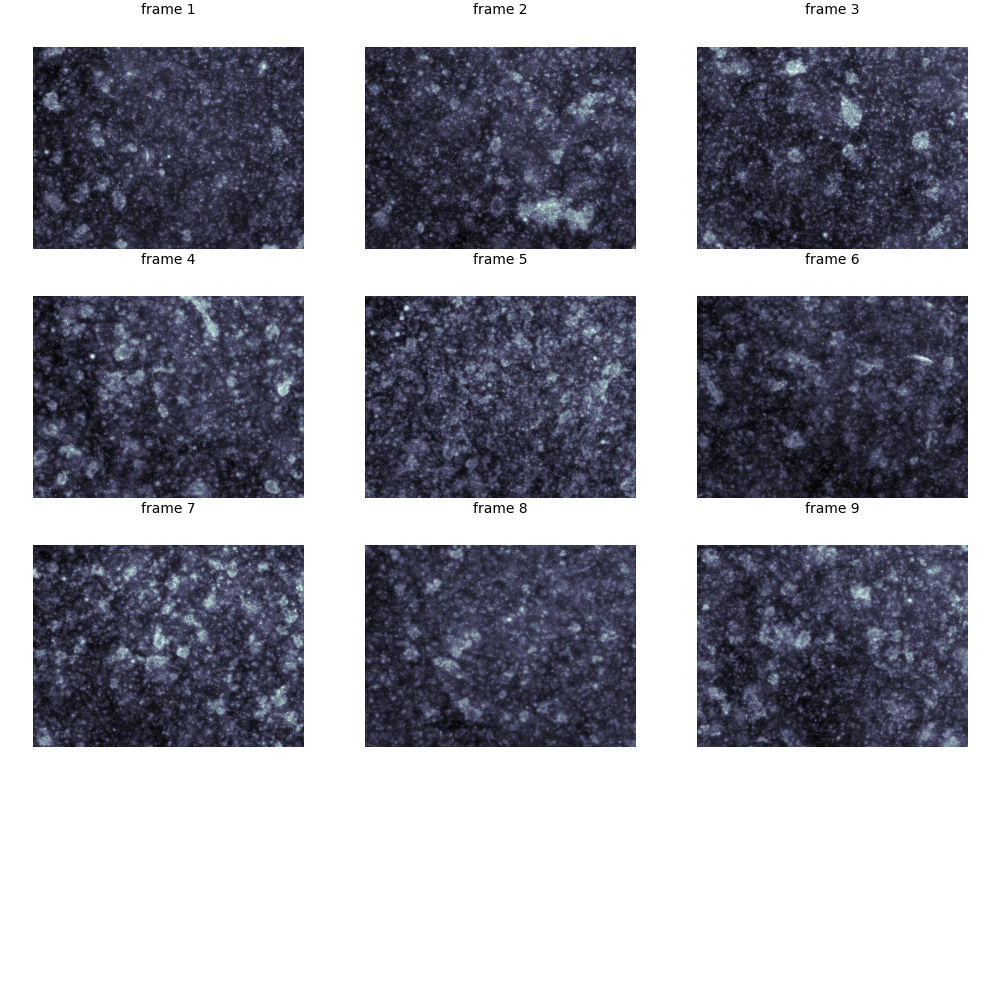

In [12]:
#####################################################
# **optional** preview of tiff files to be analyzed #
#####################################################
br_frame1 = tiff_file.imread(data_dir2 +'tr_'+frame_names[0]+'.tif')

plt.figure(figsize=(10,10))    
for i in range (arr_length):
    ax = plt.subplot(4,3,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("frame %i" % int(i + 1), fontsize=10)
    ax.matshow(br_frame1[i], cmap = 'bone') #fig.set_cmap('hot') 
    plt.axis('off')
    plt.tight_layout(pad=.25)

<IPython.core.display.Javascript object>


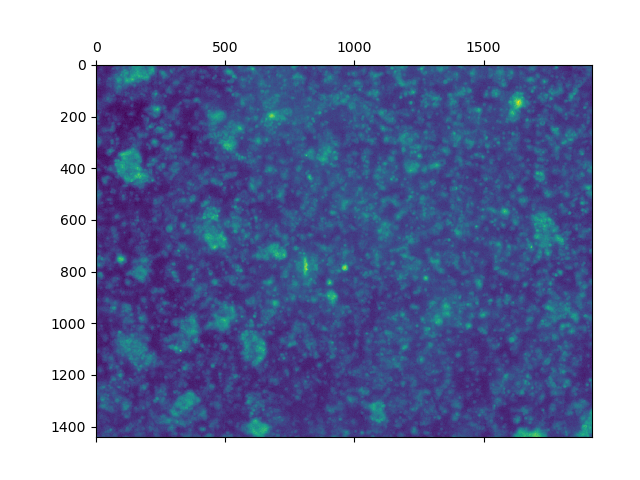

<IPython.core.display.Javascript object>


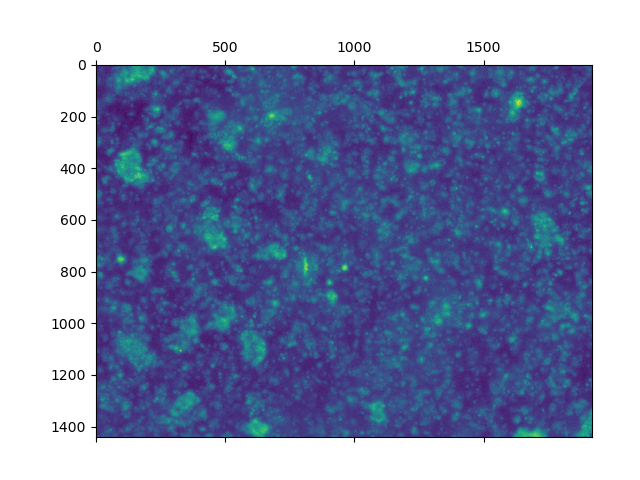

In [31]:
plt.matshow(br_frame1[0])
#plt.matshow(uf(br_frame1[0],700))
plt.matshow(br_frame1[0]*1.0 - uf(br_frame1[0],700))

In [9]:
im_array = [0.0] * int(len(files))
br_corr_im_array = [0.0] * int(len(files))
br_corr_rad_array = [0.0] * int(len(files))
mr_corr_im_array = [0.0] * int(len(files))
mr_corr_rad_array = [0.0] * int(len(files))
tr_corr_im_array = [0.0] * int(len(files))
tr_corr_rad_array = [0.0] * int(len(files))

all_xvalues = [0.0] * int(len(files))

<IPython.core.display.Javascript object>


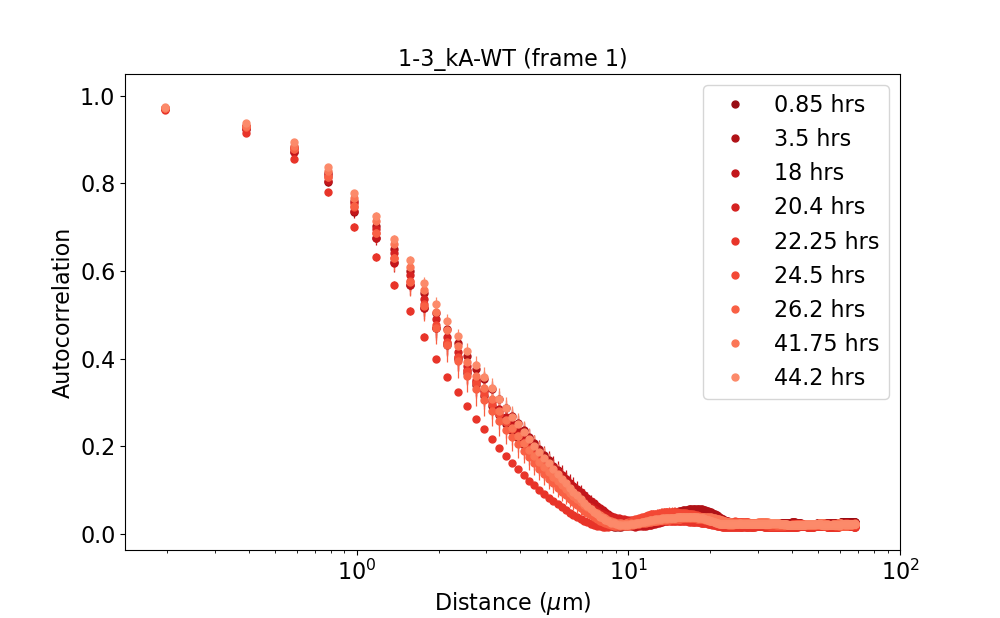

Text(0.5, 1.0, '1-3_kA-WT (frame 1)')

In [46]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

key = 0
cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    t_f = True  #use filter? (True = yes, False = no)
    size = 200  #set filter size, recommendation = 200
    br_corr_im_array[i], br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_im_array[i], mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_im_array[i], tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*0.196
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0,fontsize=font_size)

plt.xlim(0.14, 100) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [47]:
###save figure 
fig.savefig(plot_saveto+"SIA with error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


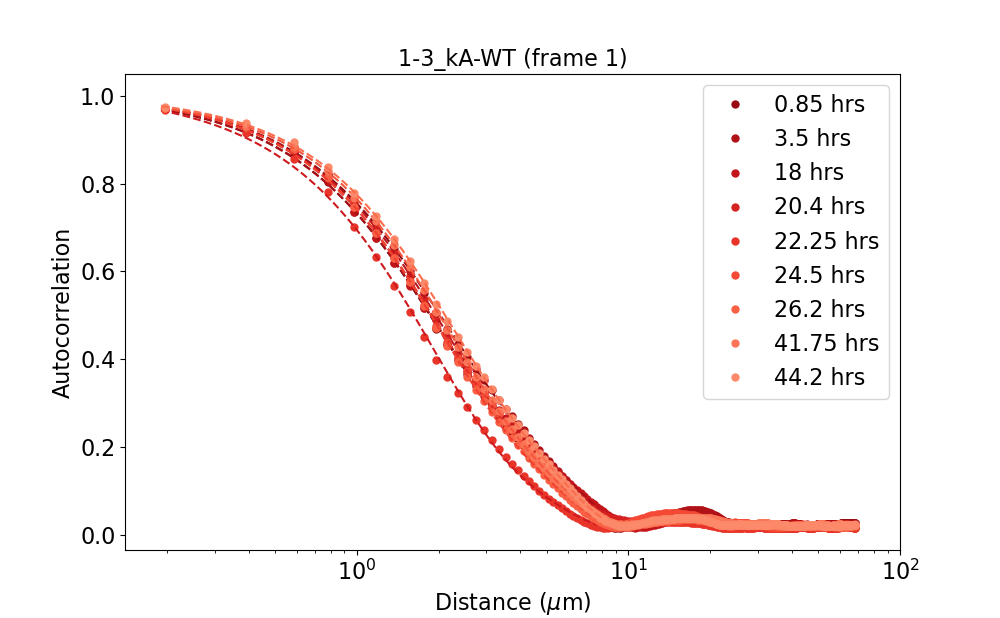

In [48]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

frame1_results_dict = {}
frame1_results_dict["time array"] = time_array
corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogx(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    fit_line = np.poly1d(np.polyfit(all_xvalues[:fit_lim], y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    a = fit_line(x_fit_values)
    plt.semilogx(x_fit_values, a,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    nearest = find_nearest(a, one_over_e)
    index, = np.where(a == nearest)
    corr_length = float(x_fit_values[index])
    
    ###saving all data & results to results dictionary 
    frame1_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame1_results_dict[time]["x vals"] = all_xvalues
    frame1_results_dict[time]["y vals"] = y_array
    frame1_results_dict[time]["y error"] = std_error_array[i]
    frame1_results_dict[time]["x fit vals"] = x_fit_values
    frame1_results_dict[time]["y fit vals"] = a
    frame1_results_dict[time]["corr length"] = corr_length
    corr_length_array[i] = corr_length
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
ax.legend(loc=0,fontsize=font_size)

plt.xlim(0.14, 100)
title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [49]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

In [50]:
print(arr_length)

9


<IPython.core.display.Javascript object>


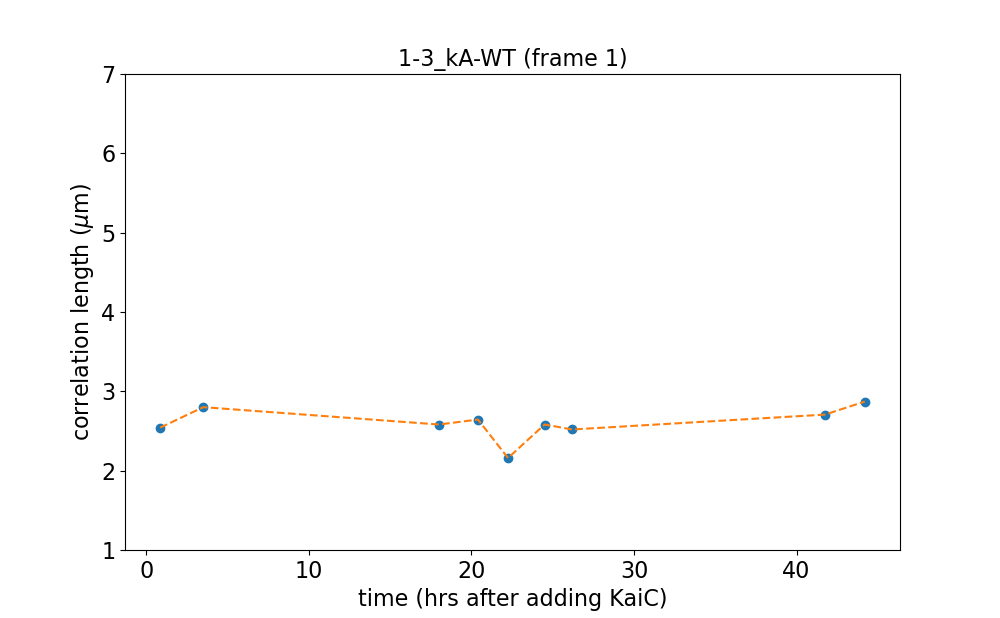

[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]


Text(0.5, 1.0, '1-3_kA-WT (frame 1)')

In [51]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

###label each point 
'''
time_array = [0] * arr_length
for i in range(arr_length):
    time_array[i] = int(i+1)
'''
#time_array = [0.5, 4.5, 8, 12, 20, 24]
print(time_array)
    
plt.plot(time_array, corr_length_array,'o')
plt.plot(time_array, corr_length_array,'--')
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,7)
title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)

In [52]:
###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

In [53]:
#print(results_dict)

<IPython.core.display.Javascript object>


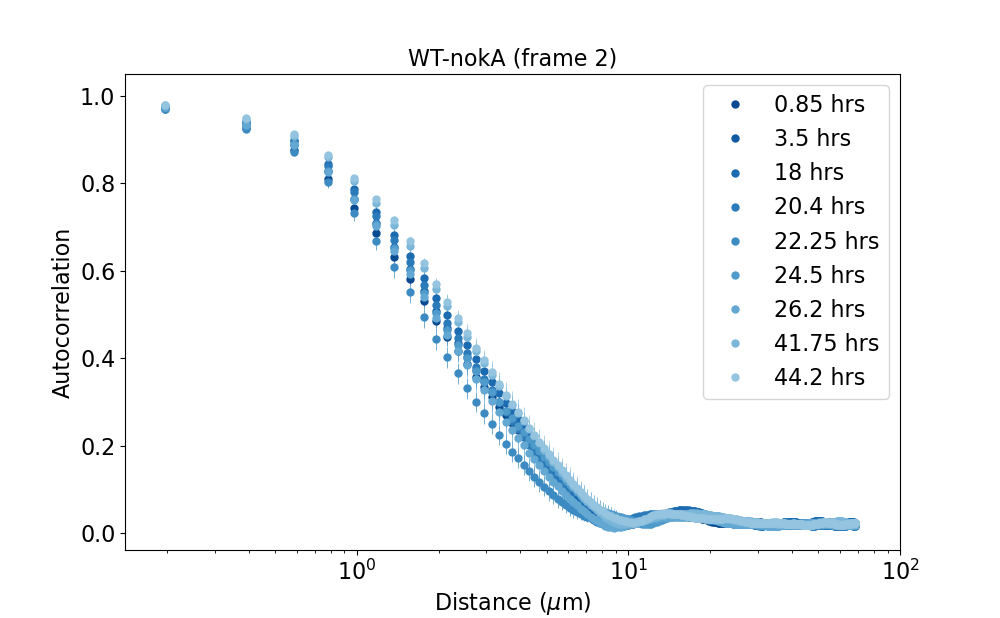

Text(0.5, 1.0, 'WT-nokA (frame 2)')

In [54]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

key = 1
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs"  #"time "+(full_filename.split('\\')[-1])[12:-4]
    t_f = True
    size = 200
    br_corr_im_array[i], br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_im_array[i], mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_im_array[i], tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*0.196
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, fontsize=font_size)

plt.xlim(0.14, 100)
title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [55]:
###save figure 
fig.savefig(plot_saveto+"SIA with error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


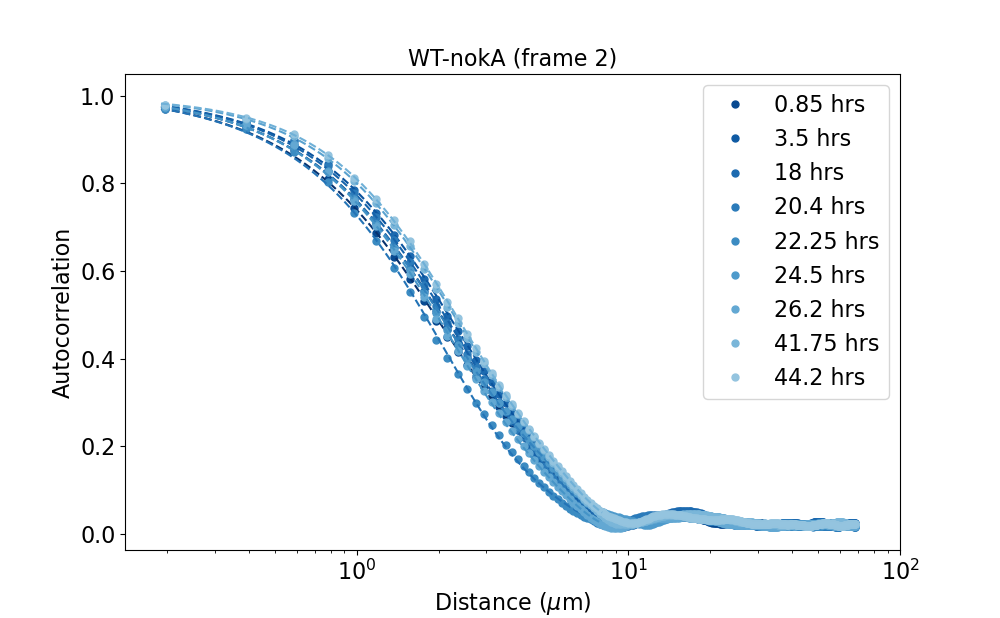

In [56]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

frame2_results_dict = {}
frame2_results_dict["time array"] = time_array
corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogx(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    fit_line = np.poly1d(np.polyfit(all_xvalues[:fit_lim], y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    a = fit_line(x_fit_values)
    plt.semilogx(x_fit_values, a,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    nearest = find_nearest(a, one_over_e)
    index, = np.where(a == nearest)
    corr_length = float(x_fit_values[index])
    
    ###saving all data & results to results dictionary 
    frame2_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame2_results_dict[time]["x vals"] = all_xvalues
    frame2_results_dict[time]["y vals"] = y_array
    frame2_results_dict[time]["y error"] = std_error_array[i]
    frame2_results_dict[time]["x fit vals"] = x_fit_values
    frame2_results_dict[time]["y fit vals"] = a
    frame2_results_dict[time]["corr length"] = corr_length
    corr_length_array[i] = corr_length
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
ax.legend(loc=0, fontsize=font_size)

plt.xlim(0.14, 100)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame2_results_dict, file_to_write)

In [57]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


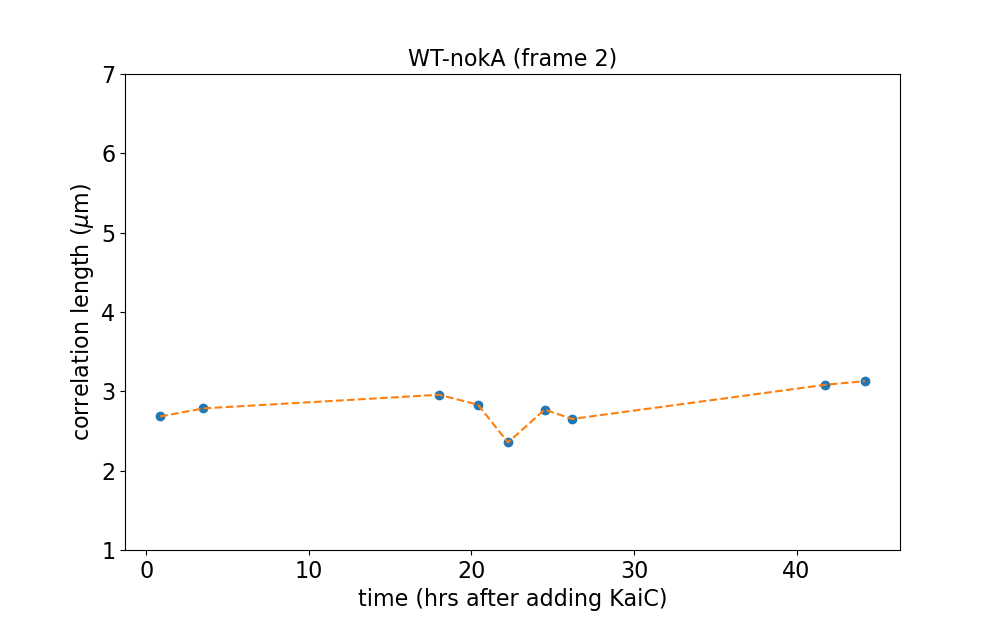

[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]


In [58]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

###label each point 
print(time_array)
    
plt.plot(time_array, corr_length_array,'o')
plt.plot(time_array, corr_length_array,'--')
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,7)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)

###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


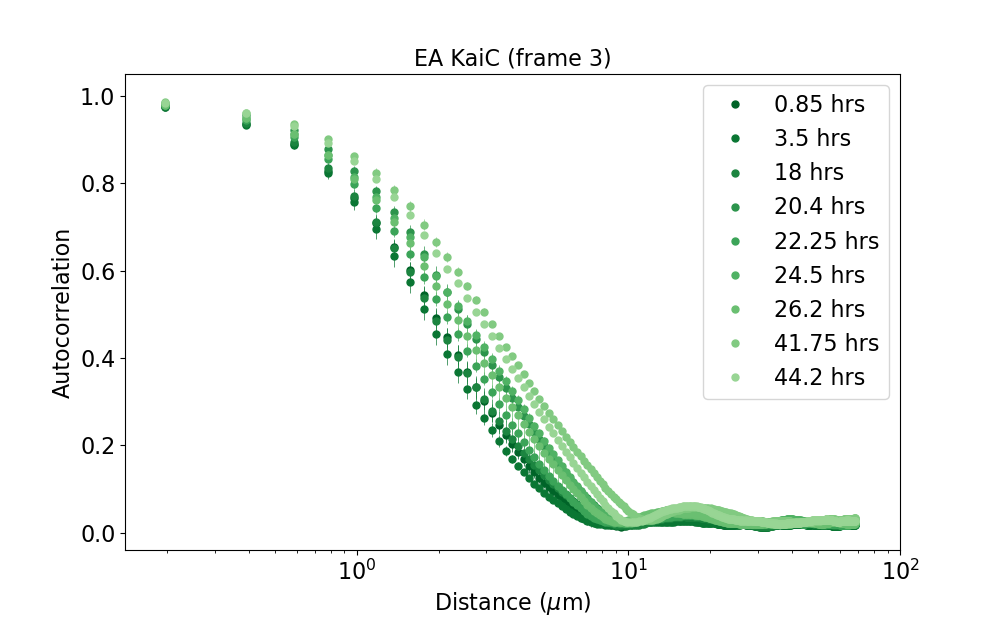

Text(0.5, 1.0, 'EA KaiC (frame 3)')

In [59]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

key = 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    t_f = True
    size = 200
    br_corr_im_array[i], br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_im_array[i], mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_im_array[i], tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*0.196
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, fontsize=font_size)

plt.xlim(0.14, 100)
title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [60]:
###save figure 
fig.savefig(plot_saveto+"SIA with error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


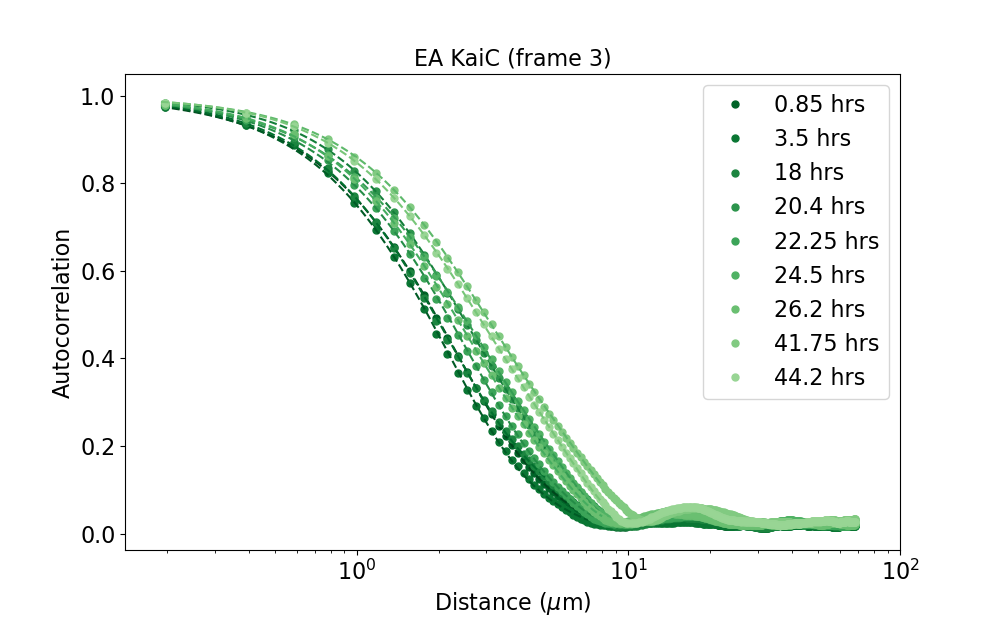

In [61]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

frame3_results_dict = {}
frame3_results_dict["time array"] = time_array
corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogx(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    fit_line = np.poly1d(np.polyfit(all_xvalues[:fit_lim], y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    a = fit_line(x_fit_values)
    plt.semilogx(x_fit_values, a,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    nearest = find_nearest(a, one_over_e)
    index, = np.where(a == nearest)
    corr_length = float(x_fit_values[index])
    
    ###saving all data & results to results dictionary 
    frame3_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame3_results_dict[time]["x vals"] = all_xvalues
    frame3_results_dict[time]["y vals"] = y_array
    frame3_results_dict[time]["y error"] = std_error_array[i]
    frame3_results_dict[time]["x fit vals"] = x_fit_values
    frame3_results_dict[time]["y fit vals"] = a
    frame3_results_dict[time]["corr length"] = corr_length
    corr_length_array[i] = corr_length
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
ax.legend(loc=0,fontsize=font_size)

plt.xlim(0.14, 100)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame3_results_dict, file_to_write)

In [62]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


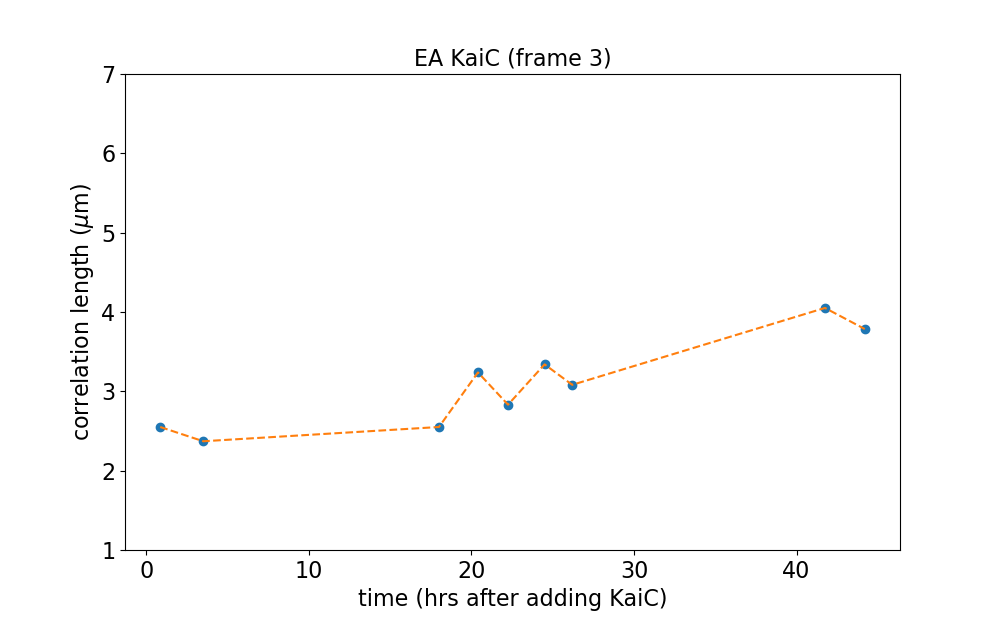

[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]


In [63]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

###label each point 
print(time_array)
    
plt.plot(time_array, corr_length_array,'o')
plt.plot(time_array, corr_length_array,'--')
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.ylim(1,7)
plt.title(title, fontsize=font_size)

###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


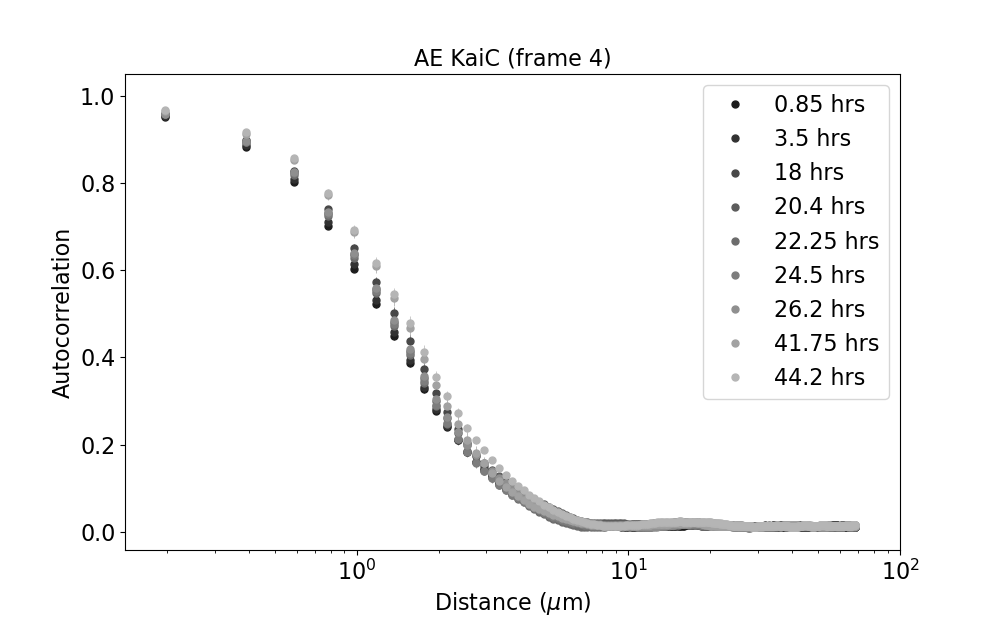

Text(0.5, 1.0, 'AE KaiC (frame 4)')

In [64]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

key = 3
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    t_f = True
    size = 200
    br_corr_im_array[i], br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_im_array[i], mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_im_array[i], tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*0.196
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, fontsize=font_size)

plt.xlim(0.14, 100)
title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [65]:
###save figure 
fig.savefig(plot_saveto+"SIA with error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


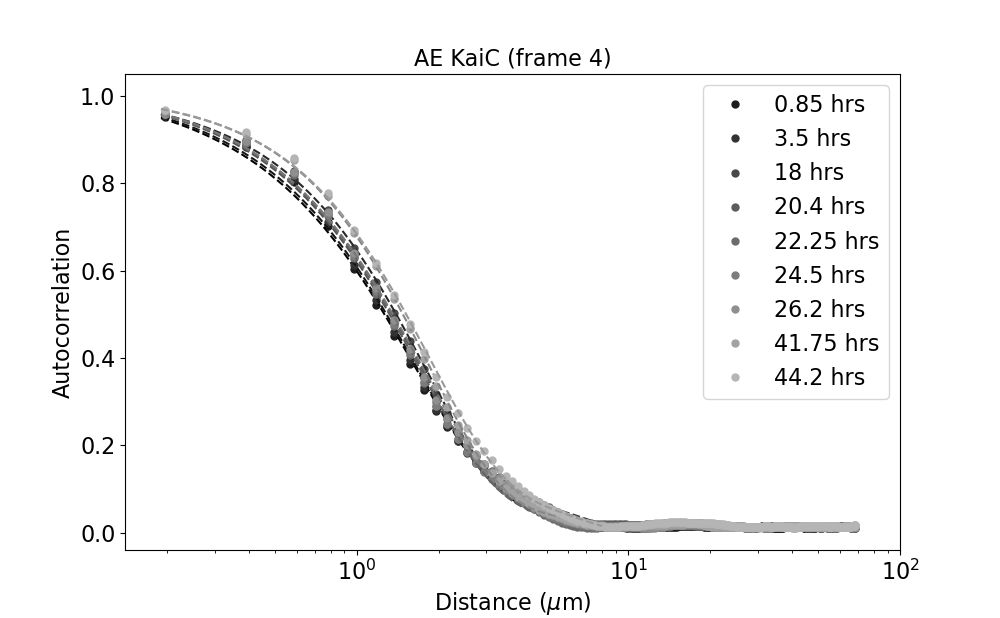

In [66]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

frame4_results_dict = {}
frame4_results_dict["time array"] = time_array
corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogx(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    fit_line = np.poly1d(np.polyfit(all_xvalues[:fit_lim], y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    a = fit_line(x_fit_values)
    plt.semilogx(x_fit_values, a,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    nearest = find_nearest(a, one_over_e)
    index, = np.where(a == nearest)
    corr_length = float(x_fit_values[index])
    
    ###saving all data & results to results dictionary 
    frame4_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame4_results_dict[time]["x vals"] = all_xvalues
    frame4_results_dict[time]["y vals"] = y_array
    frame4_results_dict[time]["y error"] = std_error_array[i]
    frame4_results_dict[time]["x fit vals"] = x_fit_values
    frame4_results_dict[time]["y fit vals"] = a
    frame4_results_dict[time]["corr length"] = corr_length
    corr_length_array[i] = corr_length
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
ax.legend(loc=0,fontsize=font_size)

plt.xlim(0.14, 100)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title,fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame4_results_dict, file_to_write)

In [67]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


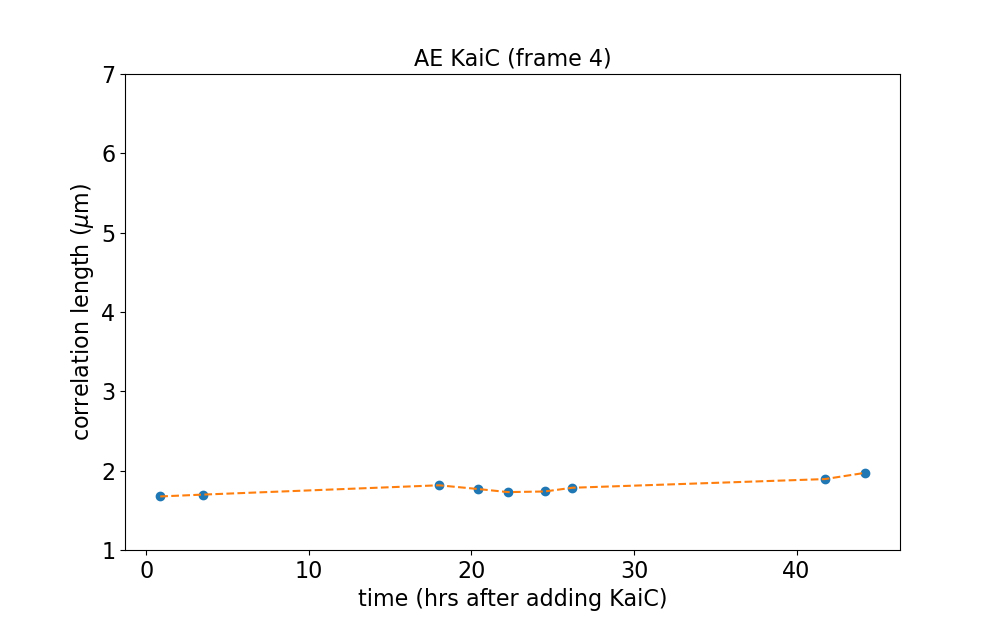

[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]


In [68]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10

###label each point 
print(time_array)
    
plt.plot(time_array, corr_length_array,'o')
plt.plot(time_array, corr_length_array,'--')
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,7)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title,fontsize=font_size)

###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)